## Not working great, but keeping as ref. Ignore :)

In [2]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np

In [3]:
!ls /mnt/c/Users/Johno/Downloads/VID_*.mp4

/mnt/c/Users/Johno/Downloads/VID_20250129_100610.mp4
/mnt/c/Users/Johno/Downloads/VID_20250129_101329.mp4
/mnt/c/Users/Johno/Downloads/VID_20250129_101624.mp4
/mnt/c/Users/Johno/Downloads/VID_20250129_101932.mp4


In [4]:
video_fname = '/mnt/c/Users/Johno/Downloads/VID_20250129_101624.mp4'

I want to extract frames from this video, and ultimately make a mosaic from them. I want to grab a few frames from every 300ms of video and keep the sharpest. Frames should be center-cropped into a square 600px wide (configurable). Can you help me out with code for this?

In [5]:
def get_sharpness(img):
    """Calculate image sharpness using Laplacian variance"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def center_crop_square(img, size=512, offsetx=0, offsety=0):
    """Crop image to square from center"""
    h, w = img.shape[:2]
    min_dim = min(h, w)
    start_y = offsety + (h - min_dim) // 2
    start_x = offsetx + (w - min_dim) // 2
    cropped = img[start_y:start_y+min_dim, start_x:start_x+min_dim]
    return cv2.resize(cropped, (size, size))

def extract_best_frames(video_path, interval_ms=300, frames_per_interval=5, crop_size=600,  offsetx=0, offsety=0):
    """Extract sharpest frame from each time interval"""
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps * (interval_ms / 1000))
    frames_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    best_frames = []
    current_frames = []
    current_sharpness = []
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        if frame_count % frame_interval == 0:
            # If we have collected frames for an interval, keep the sharpest
            if current_frames:
                best_idx = np.argmax(current_sharpness)
                best_frames.append(center_crop_square(current_frames[best_idx], crop_size, offsetx, offsety))
            current_frames = []
            current_sharpness = []
            
        if len(current_frames) < frames_per_interval:
            current_frames.append(frame)
            current_sharpness.append(get_sharpness(frame))
            
        frame_count += 1
    
    cap.release()
    return best_frames

In [6]:
# Let's extract the frames
best_frames = extract_best_frames(video_fname, crop_size=512,  offsetx=0, offsety=250, interval_ms=500)
print(f"Extracted {len(best_frames)} frames")

Extracted 209 frames


In [7]:
best_frames[0].shape

(512, 512, 3)

In [12]:
%%aip 0
Save the frames to a 'frames' folder in the same dir as the video

In [18]:
# import os

# # Create frames directory next to video
# video_dir = os.path.dirname(video_fname)
# frames_dir = os.path.join(video_dir, 'frames')
# os.makedirs(frames_dir, exist_ok=True)

# # Save frames as PNG files
# for i, frame in enumerate(best_frames):
#     frame_path = os.path.join(frames_dir, f'frame_{i:04d}.png')
#     cv2.imwrite(frame_path, frame)

# print(f"Saved {len(best_frames)} frames to {frames_dir}")

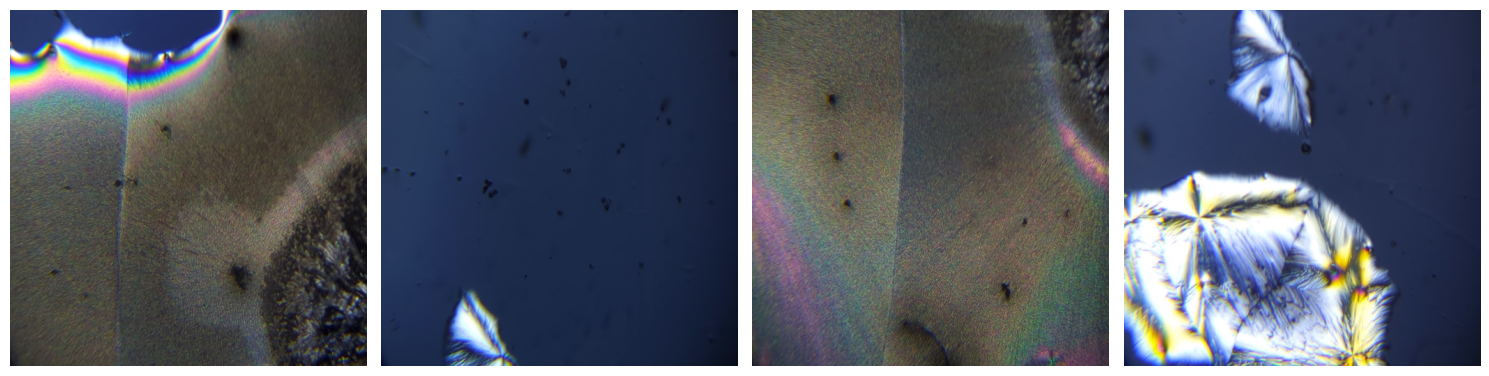

In [8]:
# Display some frames
fig, axes = plt.subplots(1, min(4, len(best_frames)), figsize=(15, 4))
for i, ax in enumerate(axes):
    ax.imshow(cv2.cvtColor(best_frames[i*10+10], cv2.COLOR_BGR2RGB))
    ax.axis('off')
plt.tight_layout()

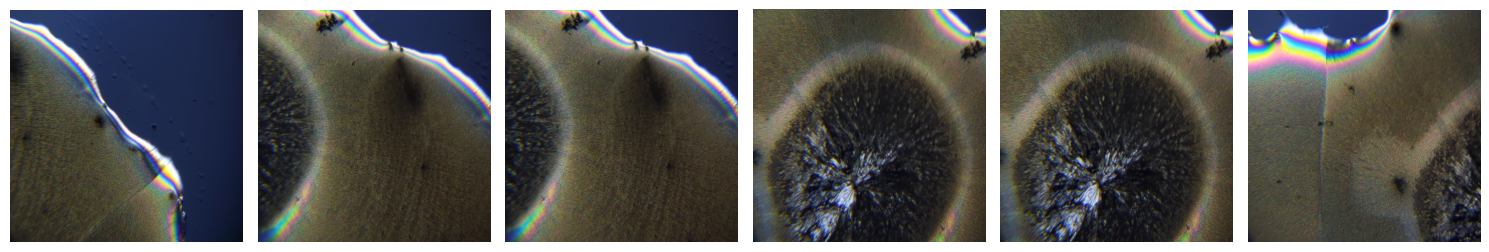

In [9]:
# And some in a row
fig, axes = plt.subplots(1, min(6, len(best_frames)), figsize=(15, 4))
for i, ax in enumerate(axes):
    ax.imshow(cv2.cvtColor(best_frames[i+4], cv2.COLOR_BGR2RGB))
    ax.axis('off')
plt.tight_layout()

In [10]:
STITCH_MODE = cv2.Stitcher_SCANS  # or cv2.Stitcher_PANORAMA
stitcher = cv2.Stitcher_create(mode=STITCH_MODE)
stitcher.setPanoConfidenceThresh(0.5)
stitcher.setCompositingResol(1) # 1 means full resolution
stitcher.setSeamEstimationResol(0.05) # relative to full resolution

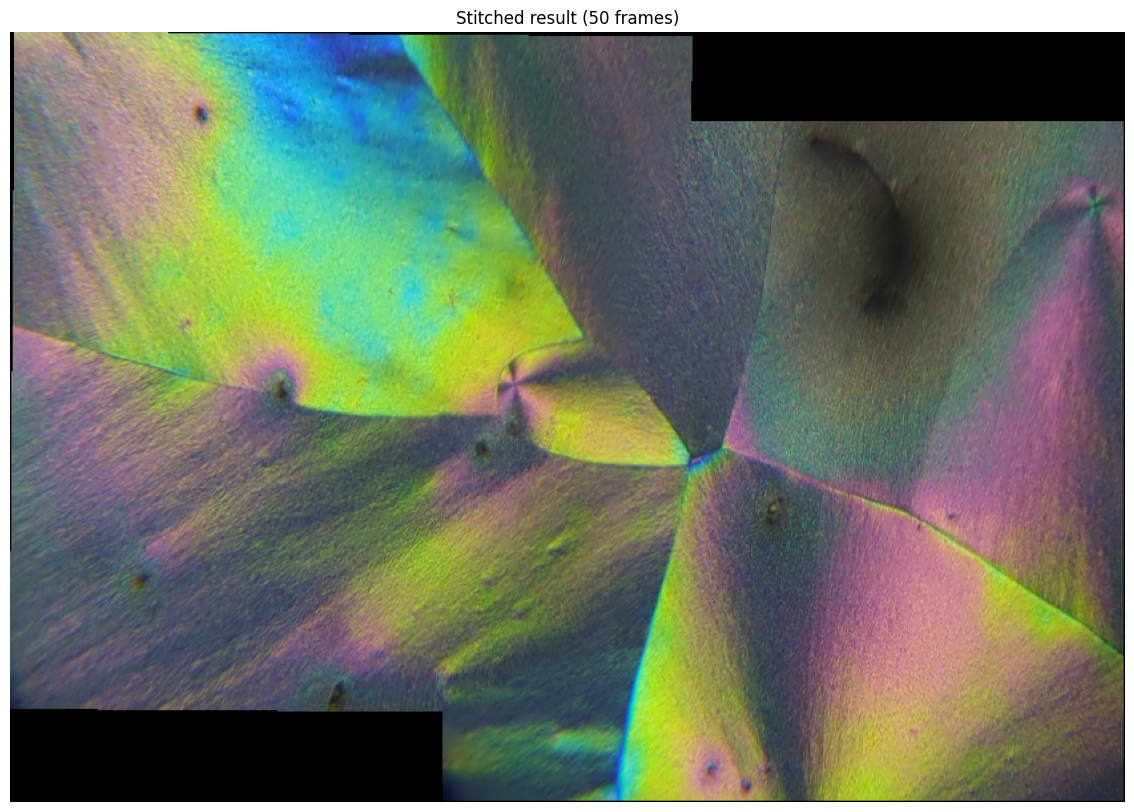

In [11]:
def stitch_incrementally(frames, start_idx=0, end_idx=None, step=2, wsize=5, maxfails=5):
    if end_idx is None: end_idx = len(frames)
    if end_idx - start_idx < 2: return None, None
    result = frames[start_idx]
    fails = 0
    for i in range(start_idx + 1, end_idx, step):
        print(f"Stitching frame {i}/{end_idx-1}...", end='\r')
        status, new_result = stitcher.stitch([result]+list(frames[i:i+wsize]))
        if status != cv2.Stitcher_OK:
            print(f"\nStitching failed at frame {i}. Status: {status}")
            fails += 1
            if fails>maxfails: return result, i
        else:
            result = new_result
    return result, end_idx

result, last_idx = stitch_incrementally(best_frames, start_idx=0, end_idx=50)

if result is not None:
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Stitched result ({last_idx} frames)')
    plt.show()